## Dataset Information

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels

(1 = dog, 0 = cat).

## Import Modules

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from numpy import mean
from numpy import std
import numpy as np #for mathematical calcuations
import pandas as pd #used for dataframes
import tensorflow as tf
import matplotlib.pyplot as plt #to plot
import warnings
import os #for directories manipulation
import tqdm #to track progress by progress bar
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold #for K-validation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Create Dataframe for Input and Output

In [ ]:
import random
random.seed(1)

input_path = []
label = []

#reads path from drectores
for class_name in os.listdir("AI"):
    for path in os.listdir("AI/"+class_name):
      #appends labels from cat folder and assigns label 0
        if class_name == 'Cat':
            label.append(0)
        else:
          #appends labels from dog folder and assigns label 1
            label.append(1)
        input_path.append(os.path.join("AI", class_name, path))
print(input_path[0], label[0])

AI/Cat/14.jpg 0


In [ ]:
#changes images into dataframe, basically values with label 0 or 1
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True) #returning rows in radom orer
df.head()

images  label
0  AI/Cat/130.jpg      0
1    AI/Cat/7.jpg      0
2  AI/Cat/381.jpg      0
3  AI/Cat/118.jpg      0
4  AI/Dog/228.jpg      1

In [ ]:
# delete db files
df = df[df['images']!='AI/Dog/Thumbs.db']
df = df[df['images']!='AI/Cat/Thumbs.db']
df = df[df['images']!='AI/Cat/666.jpg']
df = df[df['images']!='AI/Dog/11702.jpg']
len(df)

500

## Exploratory Data Analysis

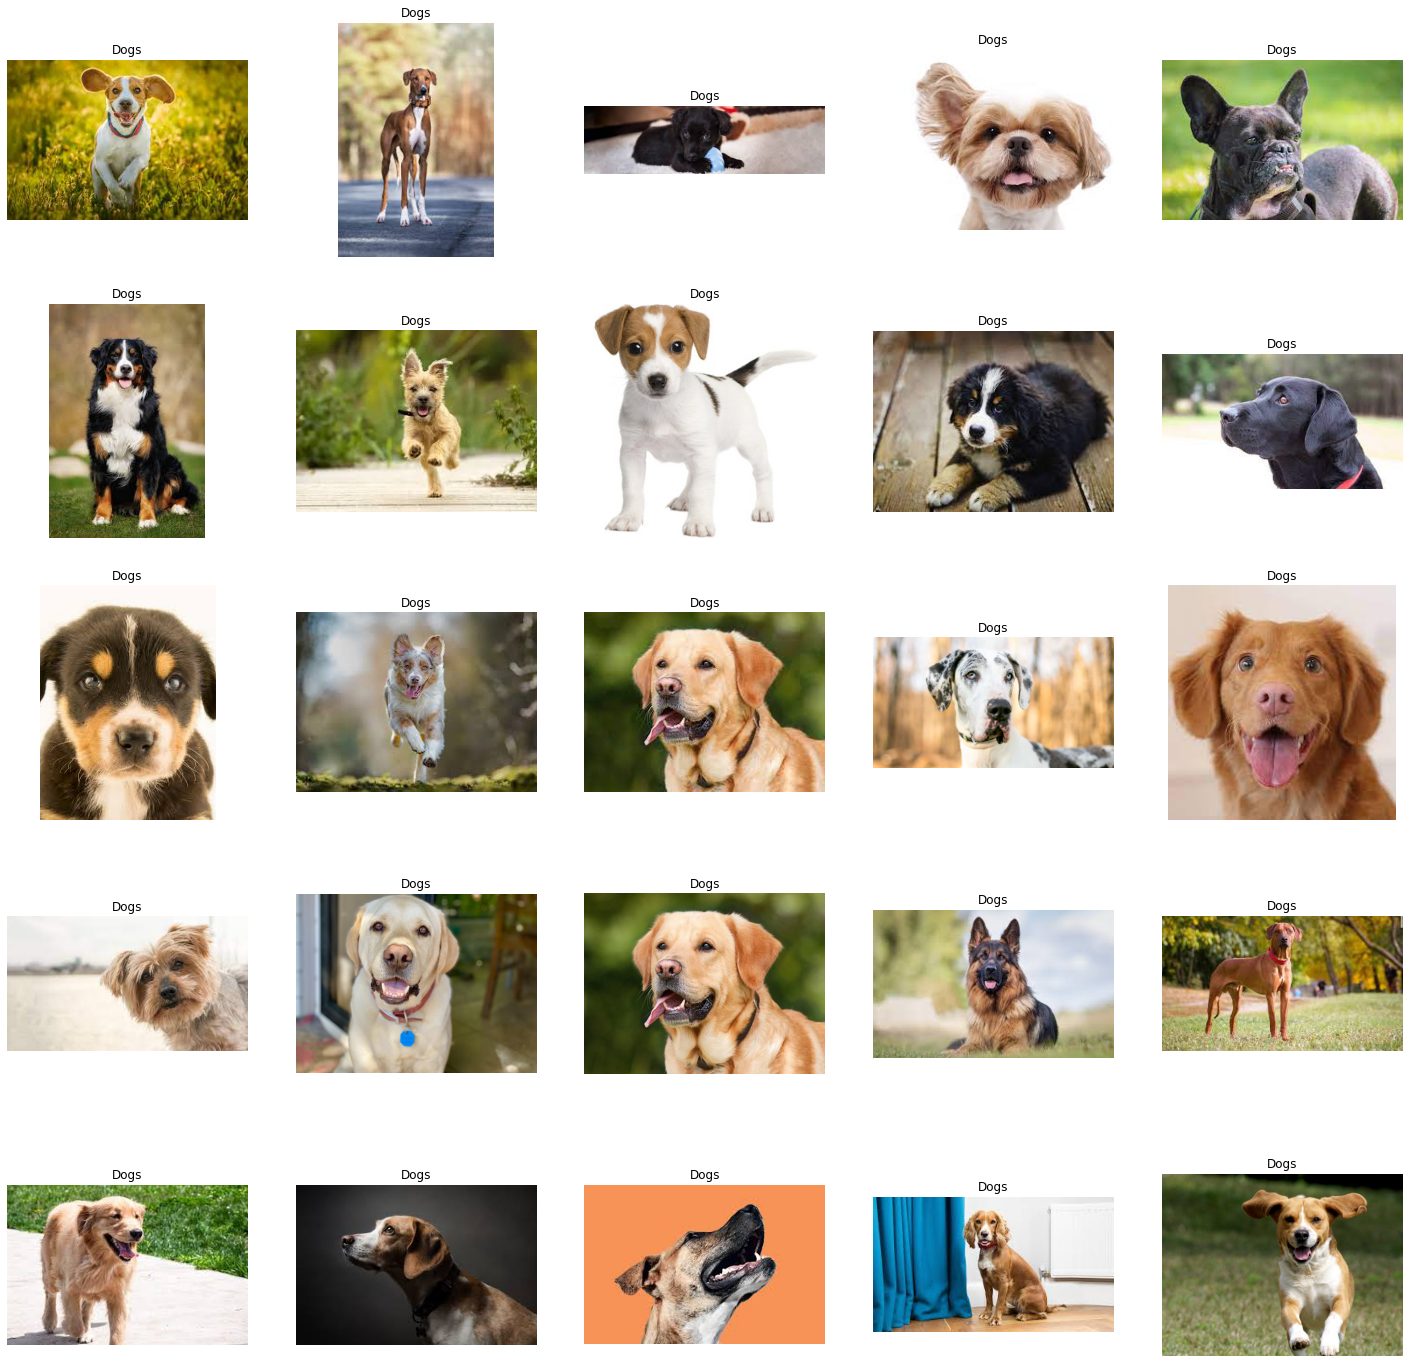

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files): #converts data object of Dog into enmrate object
    plt.subplot(5,5, index+1)
    img = load_img(file) #loading the image
    img = np.array(img) #converting into array in order to plot
    plt.imshow(img)
    plt.title('Dogs') 
    plt.axis('off')

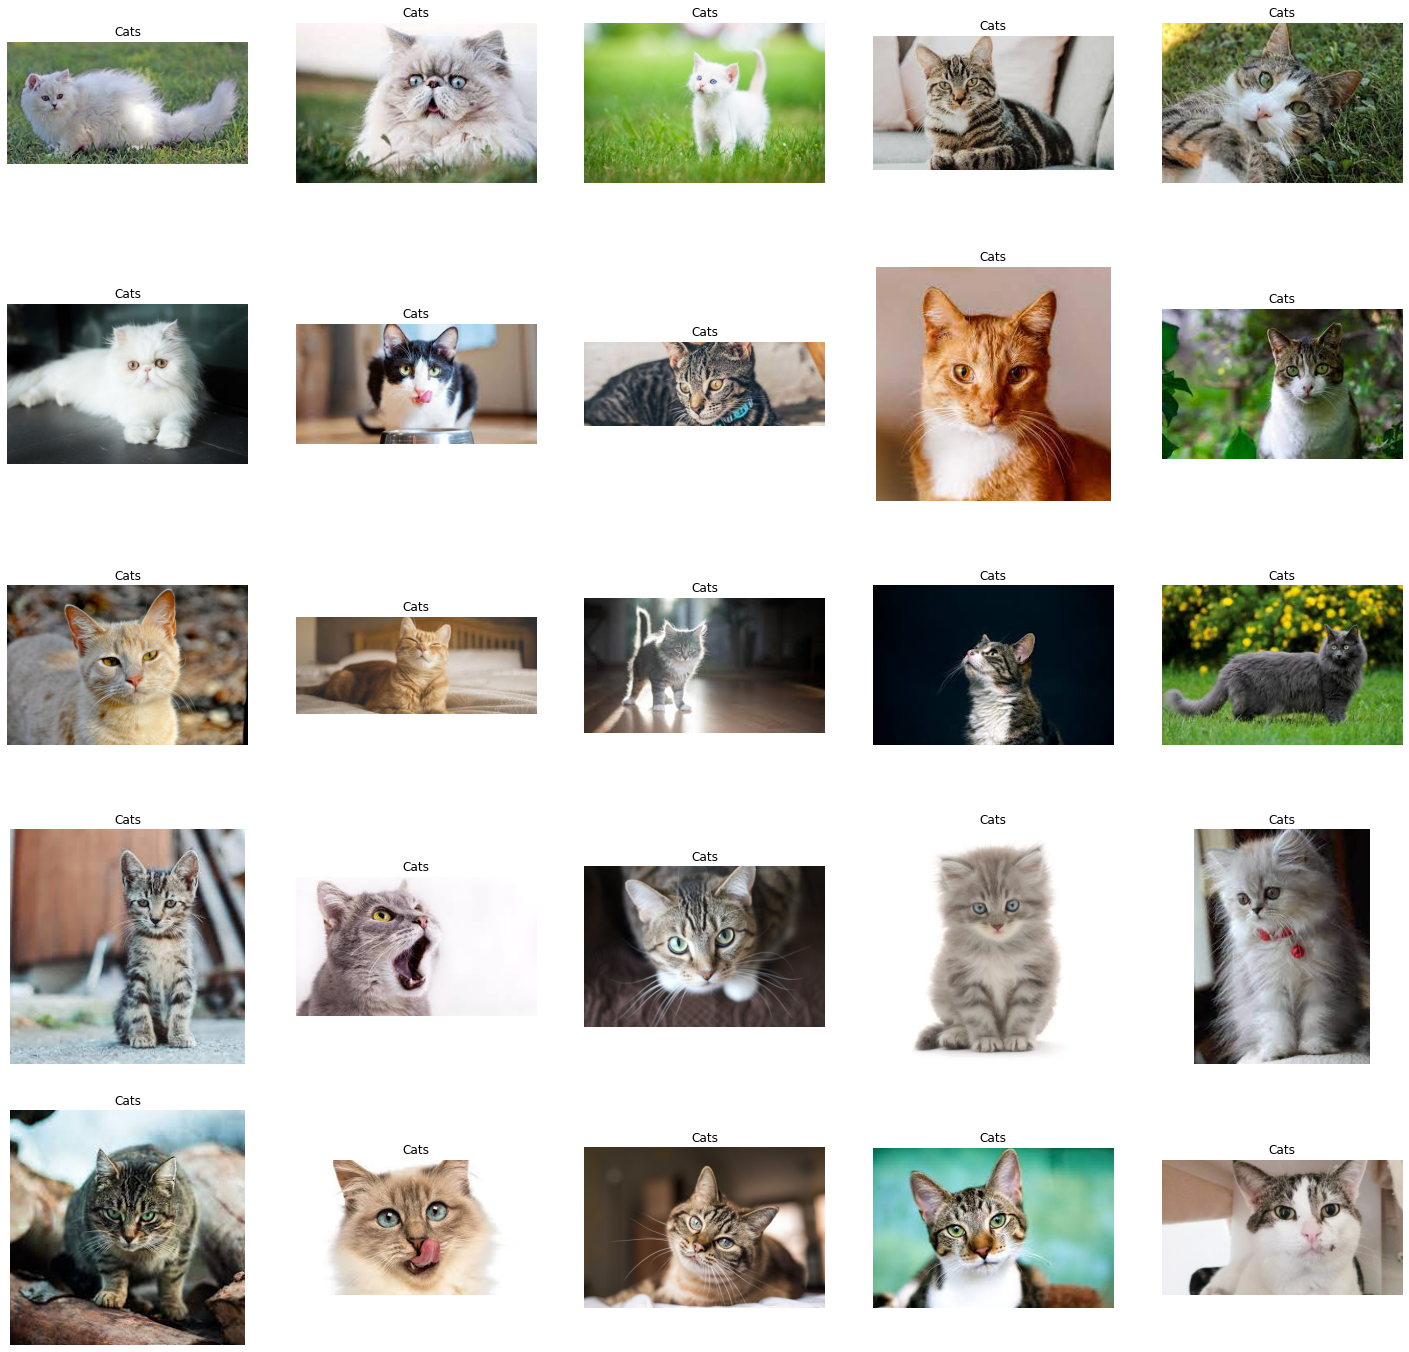

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files): #converts data object of Cats into enmrate object
    plt.subplot(5,5, index+1)
    img = load_img(file) #Loading image
    img = np.array(img) #converting into array in order to plot
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

## Create DataGenerator for the Images

In [ ]:
df['label'] = df['label'].astype('str') #converting labels into strings

In [ ]:
df.head()

images label
0  AI/Cat/130.jpg     0
1    AI/Cat/7.jpg     0
2  AI/Cat/381.jpg     0
3  AI/Cat/118.jpg     0
4  AI/Dog/228.jpg     1

## Model Creation

In [ ]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 400 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [ ]:
#libraries for cnn
from keras import Sequential 
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

kfold = KFold(3, shuffle=True, random_state=1) #defining number of folds
scores, histories = list(), list()
for train_ix, test_ix in kfold.split(train): #loop to iterate through each fold in KNN
  model = Sequential([
                      Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)), #conv layer
                      MaxPool2D((2,2)), #Max pool layer to decrease number of weights
                      Conv2D(32, (3,3), activation='relu'), #conv layer
                      MaxPool2D((2,2)), #Max pool layer to decrease number of weights
                      Conv2D(64, (3,3), activation='relu'), #conv layer
                      MaxPool2D((2,2)), #Max pool layer to decrease number of weights
                      Flatten(), #to make it 1D
                      Dense(512, activation='relu'),
                      Dense(1, activation='sigmoid')
  ])
  opt = tf.keras.optimizers.SGD(lr=0.01, momentum =0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tfa.metrics.FBetaScore(num_classes=2, average="micro", threshold = 0.9)])
  model.summary()
  history = model.fit(train_iterator, epochs=100, validation_data=val_iterator)
  # evaluate model
  acc = model.evaluate(val_iterator, verbose=1)
  # stores scores
  scores.append(acc)
  histories.append(history)

print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)      

## Visualization of Results

In [ ]:
acc = history.history['accuracy'] #storing accuracy in acc variable
val_acc = history.history['val_accuracy'] #storing validatng accuracy in val_acc variable
epochs = range(len(acc))

#plotting accuracy plot
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss'] #storing loss in loss variable
val_loss = history.history['val_loss'] #storing val_loss in val_loss variable
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()